## Main task

In this exercise, we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app to classify images of dogs according to their breed.  At the end of the project, our code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. 

In the real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Our imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write our Algorithm
* [Step 7](#step7): Test our Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

In [1]:
from sklearn.datasets import load_files       
from glob import glob
from tqdm import tqdm
from PIL import ImageFile 

import numpy as np
import matplotlib.pyplot as plt                        
%matplotlib inline  

import random
import cv2
import warnings
warnings.filterwarnings('ignore')

from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

from extract_bottleneck_features import *

Using TensorFlow backend.


### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
def load_dataset(path):
    """
    Load train, test and validation datasets
    :param path: file path to data
    :return: data files and their corresponding targets
    """
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/dog_images/train')
valid_files, valid_targets = load_dataset('data/dog_images/valid')
test_files, test_targets = load_dataset('data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


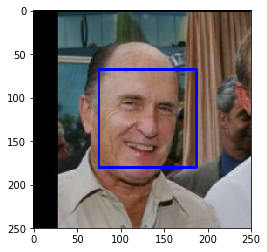

In [4]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x, y, w, h) in faces:
    # add bounding box to color image
    cv2.rectangle(img, (x, y),(x + w, y + h),(255, 0, 0), 2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
def face_detector(img_path):
    """
    Detect whether there's a human face in image stored at img_path
    :param img_path: string-valued file location
    :return: "True" if face is detected in image and "False" otherwise
    """
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  However, you will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# test the performance of the face_detector algorithm on the images in human_files_short and dog_files_short
print('Percentage of the first 100 images in `human_files` to have a detected human face:',
     np.sum([face_detector(i) for i in human_files_short])/ 100 * 100)
print('Percentage of the first 100 images in `dog_files` to have a detected human face:',
     np.sum([face_detector(i) for i in dog_files_short])/100 * 100)

Percentage of the first 100 images in `human_files` to have a detected human face: 100.0
Percentage of the first 100 images in `dog_files` to have a detected human face: 12.0


This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users).

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
warnings.filterwarnings('ignore')

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

W0608 11:01:38.909754 140735916036992 deprecation_wrapper.py:119] From /anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0608 11:01:38.924913 140735916036992 deprecation_wrapper.py:119] From /anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0608 11:01:38.929765 140735916036992 deprecation_wrapper.py:119] From /anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0608 11:01:38.951057 140735916036992 deprecation_wrapper.py:119] From /anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0608 11:01:38.951890 140

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
def path_to_tensor(img_path):
    """
    Load, resize and convert image to an array, which is then resized to a tensor 
    :param img_path: string-valued file path to a color image
    :return: a 4D tensor suitable for supplying to a Keras CNN
    """
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """
    Load, resize and convert multiple images to an array, which is then resized to a tensor 
    :param img_paths: Numpy array of string-valued image paths
    :return: a 4D tensor with shape (nb_samples, 224, 224, 3)
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
def ResNet50_predict_labels(img_path):
    """
    Extract prediction from ResNet-50 model for image located at img_path
    :param img_path: string-valued image path
    :return: an integer corresponding to the model's predicted object class, 
    """
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
def dog_detector(img_path):
    """
    Detect whether there's a dog face in image stored at img_path
    :param img_path: string-valued file location
    :return: "True" if dog face is detected in image and "False" otherwise
    """
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

In [11]:
# test the performance of the dog_detector function on the images in human_files_short and dog_files_short
print('Percentage of the first 100 images in `human_files` to have a detected dog:',
     np.sum([dog_detector(i) for i in human_files_short])/ 100 * 100)
print('Percentage of the first 100 images in `dog_files` to have a detected dog:',
     np.sum([dog_detector(i) for i in dog_files_short])/100 * 100)

Percentage of the first 100 images in `human_files` to have a detected dog: 0.0
Percentage of the first 100 images in `dog_files` to have a detected dog: 100.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  We must create your CNN _from scratch_ (so, we can't use transfer learning _yet_!), and we must attain a test accuracy of at least 1%.  In Step 5 of this notebook, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means we are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; we can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:18<00:00, 45.10it/s]


### Model Architecture

Here's an CNN architecture that we will use for this classification task:
![Sample CNN](images/sample_cnn.png)

In [13]:
model = Sequential()
orig_shape = train_tensors.shape

model.add(Conv2D(filters=16, kernel_size=2, activation='relu', input_shape=(orig_shape[1], orig_shape[2], orig_shape[3])))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(dog_names), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

W0608 11:05:50.258443 140735916036992 deprecation_wrapper.py:119] From /anaconda/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Train the Model

Train our model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

We can [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [15]:
# specify the number of epochs that we would like to use to train the model.
epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

W0608 11:05:50.410835 140735916036992 deprecation.py:323] From /anaconda/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 103s 15ms/step - loss: 4.8838 - acc: 0.0096 - val_loss: 4.8678 - val_acc: 0.0120

Epoch 00001: val_loss improved from inf to 4.86779, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/20
6680/6680 [==============================] - 111s 17ms/step - loss: 4.8621 - acc: 0.0130 - val_loss: 4.8505 - val_acc: 0.0156

Epoch 00002: val_loss improved from 4.86779 to 4.85046, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/20
6680/6680 [==============================] - 113s 17ms/step - loss: 4.8274 - acc: 0.0186 - val_loss: 4.8130 - val_acc: 0.0180

Epoch 00003: val_loss improved from 4.85046 to 4.81297, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/20
6680/6680 [==============================] - 108s 16ms/step - loss: 4.7810 - acc: 0.0207 - val_loss: 4.7799 - val_acc: 0.0156

Epoch 00004: val_loss improved from 4.81297 to 4.77986, s

### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out our model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.8612%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we will train a CNN using transfer learning.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 329us/step - loss: 11.7486 - acc: 0.1338 - val_loss: 10.2409 - val_acc: 0.2371

Epoch 00001: val_loss improved from inf to 10.24087, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 118us/step - loss: 9.3516 - acc: 0.3171 - val_loss: 9.4980 - val_acc: 0.2982

Epoch 00002: val_loss improved from 10.24087 to 9.49800, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 119us/step - loss: 8.7511 - acc: 0.3859 - val_loss: 9.1091 - val_acc: 0.3365

Epoch 00003: val_loss improved from 9.49800 to 9.10905, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 119us/step - loss: 8.3721 - acc: 0.4254 - val_loss: 8.9091 - val_acc: 0.3629

Epoch 00004: val_loss improved from 9.10905 to 8.90910, saving model to saved_

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 46.4115%


### Predict Dog Breed with the Model

In [24]:
def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.  Our CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we must use the bottleneck features from a different pre-trained model. Below are the pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

In [25]:
def set_up_pretrained_model(network):
    """
    Obtain bottleneck features, define CNN architecture and compile the model
    :param network: network that is currently available in Keras (i.e.VGG-16, VGG-19, ResNet-50, Inception or Xception)
    :return: corresponding train, valid and test sets and the initiated model
    """
    # obtain bottleneck features from another pre-trained CNN
    load_file_path = 'bottleneck_features/Dog{}Data.npz'.format(network)
    bottleneck_features = np.load(load_file_path)
    train = bottleneck_features['train']
    valid = bottleneck_features['valid']
    test = bottleneck_features['test']
    
    # define your architecture
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=train.shape[1:]))
    model.add(Dense(len(dog_names), activation='softmax'))
    print(network)
    print(model.summary())
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return train, valid, test, model


def execute_pretrained_model(network):
    """
    Train model and save weights of the best one; report performance
    :param network: network that is currently available in Keras (i.e.VGG-16, VGG-19, ResNet-50, Inception or Xception)
    :return: None
    """
    train, valid, test, model = set_up_pretrained_model(network)
    
    # train the model
    saved_file_path = 'saved_models/weights.best.{}.hdf5'.format(network)
    checkpointer = ModelCheckpoint(filepath=saved_file_path, verbose=0, save_best_only=True)
    model.fit(train, train_targets, validation_data=(valid, valid_targets),
              epochs=20, batch_size=20, callbacks=[checkpointer], verbose=0)
    
    # load the model weights with the best validation loss
    model.load_weights(saved_file_path)
    
    # calculate classification accuracy on the test dataset;
    # get index of predicted dog breed for each image in test set
    predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test]
    
    # report test accuracy
    test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
    print(network)
    print('Test accuracy: %.4f%%' % test_accuracy)
    print('---------------------------------------')
    
    
def breed_classifier(img_path):
    """
    Return the dog breed that is predicted by the best model (Xception)
    :param img_path: path to an image
    :return: predicted dog breed (e.g.: `Affenpinscher`, `Afghan_hound`, etc.)
    """
    train_xception, valid_xception, test_xception, model_xception = set_up_pretrained_model('Xception')
    model_xception.load_weights('saved_models/weights.best.{}.hdf5'.format('Xception'))
    
    # functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, 
    # and they have been imported in an earlier code cell
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # supply the bottleneck features as input to the model to return the predicted vector;
    predicted_vector = model_xception.predict(bottleneck_feature)
    # the argmax of this prediction vector gives the index of the predicted dog breed;
    # use the `dog_names` array to return the corresponding breed
    pred = dog_names[np.argmax(predicted_vector)]
    return pred.split('.')[1]

In [28]:
for nw in ['VGG16', 'VGG19', 'Resnet50', 'InceptionV3', 'Xception']:
    execute_pretrained_model(nw)

VGG16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________
None
VGG16
Test accuracy: 46.4115%
---------------------------------------
VGG19
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_______________________________________________

Result table for all pre-trained networks:

| Network     | Test accuracy (%) |
|-------------|-------------------|
| VGG16       | 46.53             |
| VGG19       | 55.26             |
| Resnet50    | 79.90             |
| InceptionV3 | 78.71             |
| Xception    | 84.45             |

Since Xception is the best model out of 5 pre-trained network, our `breed_classifier()` function was defined in the code cell above based on `Xception`.

---
<a id='step6'></a>
## Step 6: Write our Algorithm

In [29]:
def dog_breed_classifier(img_path):
    """
    Determine whether an image contains a human, dog or neither:
        - if a dog is detected in the image, return the predicted breed.
        - if a human is detected in the image, return the resembling dog breed.
        - if neither is detected in the image, provide output that indicates an error.
    :param img_path: file path to an image
    :return: predicted breed 
    """
    if dog_detector(img_path) or face_detector(img_path):
        return breed_classifier(img_path)
    else:
        print('Error! Neither human nor dog is detected.') 